In [130]:
import random
import matplotlib.pyplot as plt

def binary_to_decimal(binary_str):
    """
    Converts a binary string to a decimal integer.
    """
    decimal_num = int(binary_str, 2)
    return decimal_num


class GeneticAlgorithm:
    def __init__(self, population_size, alpha, cost, chromosome_length):
        self.population_size = population_size
        self.alpha = alpha
        self.cost = cost
        self.chromosome_length = chromosome_length
        self.population = []
        
        # Lists to store industry output (Qt) and population variance (σ_qt) values for each iteration
        self.industry_output_values = []
        self.population_variance_values = []
        
        # Lists to store industry output (Qt) and population variance (σ_qt) values for each real iteration
        self.real_industry_output_values = []
        self.real_population_variance_values = []
        
    def initialize_population(self):
        """
        Initializes the population.
        """
        self.population = [''.join(random.choice('0') for _ in range(self.chromosome_length-1))+"1" for _ in range(self.population_size)]

    def Q(self):
        """
        Calculates the sum of the decimal values of the chromosomes in a population.
        """
        return sum(binary_to_decimal(chromosome) for chromosome in self.population)
    
    def varianceOfq(self, Q):
        """
        Calculates the variance of q, the decimal values of the chromosomes in a population.
        """
        return sum((binary_to_decimal(chromosome) - 1.0 * Q / self.population_size) ** 2 for chromosome in self.population) / self.population_size
        

    def crossover_binary_strings(self, parent1, parent2, p_cross):
        """
        Performs crossover between two parents.
        """
        if random.random() < p_cross:
            crossover_point = random.randint(1, self.chromosome_length - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            return child1, child2
        else:
            return parent1, parent2

    def mutate_binary_string(self, binary_str, p_mut):
        """
        Mutates a binary string.
        """
        mutated_str = ""
        for bit in binary_str:
            if random.random() < p_mut:
                # Flip the bit if mutation probability is met
                mutated_str += '1' if bit == '0' else '0'
            else:
                mutated_str += bit
        return mutated_str
    
    def total_PiOfi(self, pt):
        """
        Calculates the sum of (pt - c) * valueOfChromosome for all chromosomes.
        """
        total_result = sum(self.PiOfi(chromosome, pt) for chromosome in self.population)
        return total_result
    
    def PiOfi(self, chromosome, pt):
        """
        Parameters:
            chromosome: A binary string representing a chromosome.
            pt: Market demand level.
        """
        value_of_chromosome = binary_to_decimal(chromosome)
        result = (pt - self.cost) * value_of_chromosome
        return result

    def evolve(self, T, crossover_factor = 0.5, mutation_factor = 0.003):
        """
        Performs the evolution of the genetic algorithm.
        """
        self.first = self.population
        self.second = self.population
        self.initialize_population()
        t = 1
        while t < T:
            t += 1
            """print(f"Market Output: {MarketOutput}")"""
            MarketOutput = self.Q()
            pt = max(0,self.alpha-MarketOutput)
            
            self.real_industry_output_values.append(MarketOutput)
            self.real_population_variance_values.append(self.varianceOfq(MarketOutput))
            
            if pt == 0:
                self.population = self.second
                self.first = self.second
                t -= 1
                MarketOutput = self.Q()
                pt = max(0,self.alpha-MarketOutput)
                self.real_industry_output_values.append(MarketOutput)
                self.real_population_variance_values.append(self.varianceOfq(MarketOutput))
                
            else:
                if 2 < len(self.real_industry_output_values):
                    self.industry_output_values.append(self.real_industry_output_values[-2])
                    self.population_variance_values.append(self.real_population_variance_values[-2])
            
            self.second = self.first
            self.first = self.population
            """for i, chromosome in enumerate(self.population, start=1):
                result = self.PiOfi(chromosome, pt)
                print(f"P{i}({chromosome}): {result}")"""


            total_output_value = self.total_PiOfi(pt)

            """print(f"Toplam PiOfi: {total_output_value}")"""

            new_generation = self.Recombination(pt)


            """print("Yeni Oluşan Popülasyon:")
            for chromosome in new_generation:
                print(chromosome)"""


            new_generation_crossover_mutate = self.crossover_and_mutate(new_generation, crossover_factor, mutation_factor)

            """print("Yeni Oluşan Popülasyon (Çaprazlama ve Mutasyon):")
            for chromosome in new_generation_crossover_mutate:
                print(chromosome)"""

            self.population=new_generation_crossover_mutate
            
        self.industry_output_values.append(self.real_industry_output_values[-1])
        self.population_variance_values.append(self.real_population_variance_values[-1])
        
        print("Final Population:")
        for chromosome in self.population:
            print(chromosome, " ",binary_to_decimal(chromosome) )

        return self.population
    
    def relative_fitness(self, chromosome, pt):
        """
        Parameters:
            chromosome: A binary string representing a chromosome.
            pt: Market demand level.
        """
        individual_PiOfi = self.PiOfi(chromosome, pt)
        total_PiOfi_value = self.total_PiOfi(pt)

        if total_PiOfi_value != 0:
            relative_fitness_value = individual_PiOfi / total_PiOfi_value
        else:
            # Eğer total_PiOfi sıfırsa, göreceli fitness de sıfırdır
            relative_fitness_value = 1.0 / population_size

        return relative_fitness_value
    
    def Recombine(self, CDFrelative_fitness_values):
        point = random.random()
        for i in range(0, len(CDFrelative_fitness_values)):
            if CDFrelative_fitness_values[i] > point: 
                return self.population[i]
        #print(CDFrelative_fitness_values)
        #print(point)
        #print(CDFrelative_fitness_values[0]<point)
    
    def Recombination(self, pt):
        """
        Parameters:
            pt: Market demand level.
        """
        relative_fitness_values = [self.relative_fitness(chromosome, pt) for chromosome in self.population]
        for i in range(1, len(relative_fitness_values)):
            relative_fitness_values[i]+=relative_fitness_values[i-1]

        # Göreceli fitness değerlerine göre sırala ve en yüksek ikiyi seç
        selectedCopies = [self.Recombine(relative_fitness_values) for i in range(0, len(self.population))]
        return selectedCopies
        
    def crossover_and_mutate(self, new_generation, crossover_factor, mutation_factor):
        """
        Parameters:
            crossover_factor: Crossover probability factor.
            mutation_factor: Gene mutation probability factor.
        """
        new_population = []

        for i in range(0, len(new_generation), 2):
            # Crossover
            parent1, parent2 = new_generation[i], new_generation[i + 1]
            child1, child2 = self.crossover_binary_strings(parent1, parent2, crossover_factor)
            new_population.extend([child1, child2])

        # Mutation
        for i in range(len(new_population)):
            new_population[i] = self.mutate_binary_string(new_population[i], mutation_factor)

        return new_population
    
    def graphOfChangeByIteration(self):
        # Plot the graphs
        plt.figure(figsize=(10, 5))

        # Industry Output (Qt)
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.industry_output_values) + 1), self.industry_output_values, label='Industry Output (Qt)')
        plt.xlabel('Iteration')
        plt.ylabel('Qt')
        plt.legend()

        # Population Variance (σ_qt)
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.population_variance_values) + 1), self.population_variance_values, label='Population Variance (σ_qt)')
        plt.xlabel('Iteration')
        plt.ylabel('σ_qt')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    def graphOfChangeByRealIteration(self):
        # Plot the graphs
        plt.figure(figsize=(10, 5))

        # Industry Output (Qt)
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.real_industry_output_values) + 1), self.real_industry_output_values, label='Industry Output (Qt)')
        plt.xlabel('real_Iteration')
        plt.ylabel('Qt')
        plt.legend()

        # Population Variance (σ_qt)
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.real_population_variance_values) + 1), self.real_population_variance_values, label='Population Variance (σ_qt)')
        plt.xlabel('real_Iteration')
        plt.ylabel('σ_qt')
        plt.legend()

        plt.tight_layout()
        plt.show()


    


In [141]:
# Example Usage:
ga = GeneticAlgorithm(population_size=20, alpha=1023, cost=0, chromosome_length=10)
ga.initialize_population()
final_population = ga.evolve(T=1000, crossover_factor = 0.5 + 6*0.001, mutation_factor = 0.003 + 6*0.00001)

Final Population:
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110011   51
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50
0000110010   50


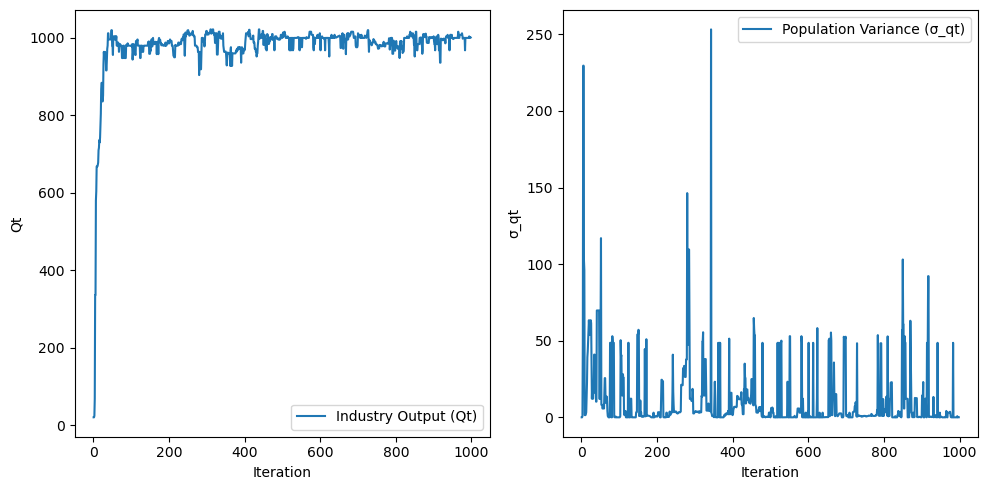

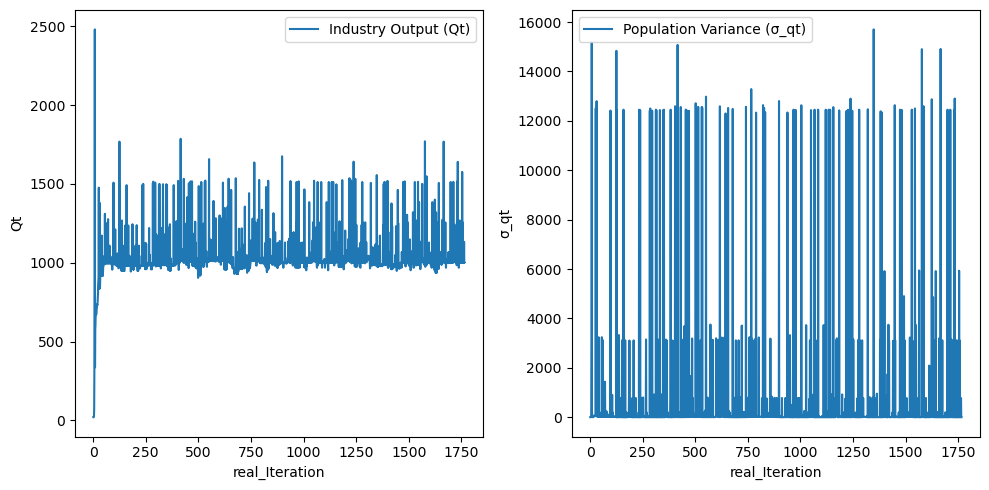

In [142]:
ga.graphOfChangeByIteration()
ga.graphOfChangeByRealIteration()

In [135]:
ga2 = GeneticAlgorithm(population_size=20, alpha=1023, cost=0, chromosome_length=10)
ga2.initialize_population()
final_population = ga2.evolve(T=1000, crossover_factor = 0.5 + 0.1 + 6*0.001, mutation_factor = 0.003 + 6*0.00001)

Final Population:
0000110100   52
0000110000   48
0000110000   48
0000110100   52
0000110100   52
0000110100   52
0000110100   52
0000110100   52
0000110000   48
0000110000   48
0000110100   52
0000110000   48
0000110100   52
0000110100   52
0000110000   48
0000110100   52
0000110000   48
0000110100   52
0000110100   52
0000110100   52


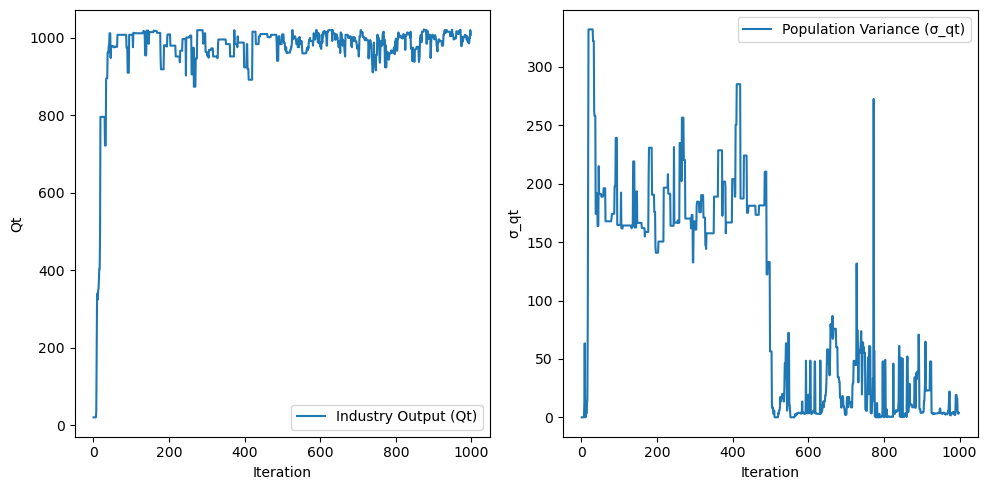

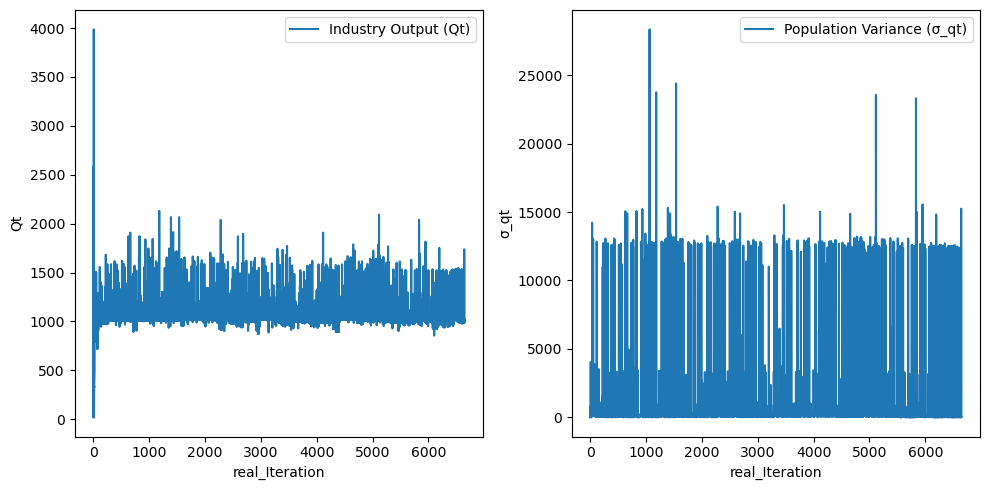

In [136]:
ga2.graphOfChangeByIteration()
ga2.graphOfChangeByRealIteration()

In [137]:
ga3 = GeneticAlgorithm(population_size=20, alpha=1023, cost=0, chromosome_length=10)
ga3.initialize_population()
final_population = ga3.evolve(T=1000, crossover_factor = 0.5 + 6*0.001, mutation_factor = 0.003 + 0.001 + 6*0.00001)

Final Population:
0000110011   51
0000110011   51
0000111011   59
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51
0000110011   51


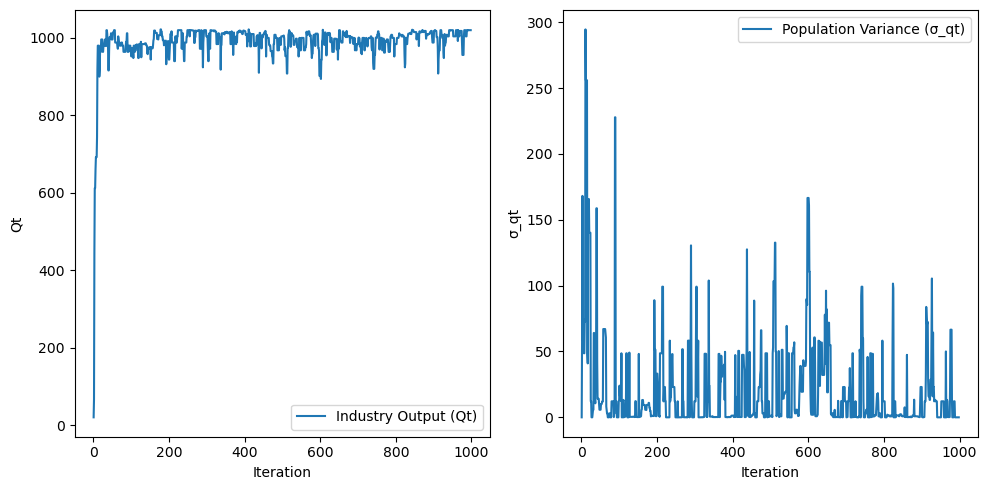

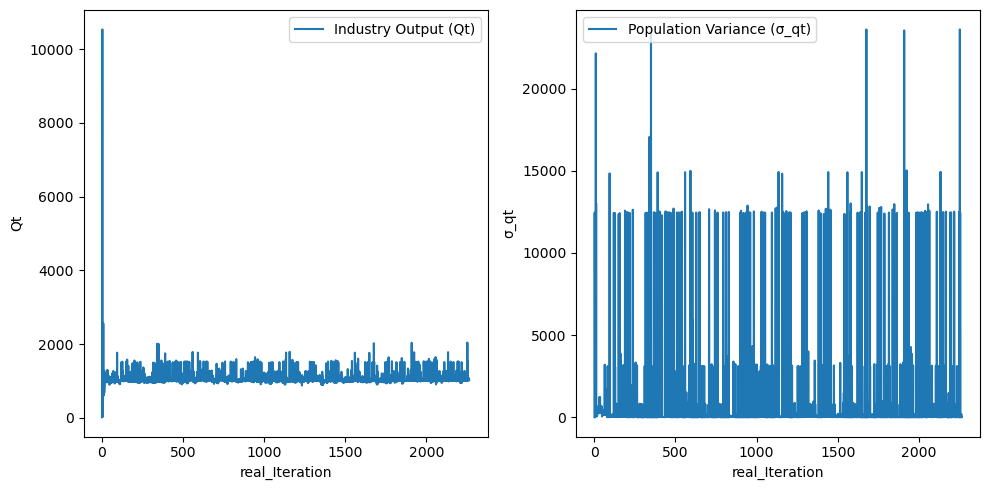

In [138]:
ga3.graphOfChangeByIteration()
ga3.graphOfChangeByRealIteration()